# Ejercicio 1: clasificación MNIST
<img src="mnist.png" width="500">
http://cs231n.github.io/convolutional-networks/

### Paso 1: Importar librerías y módulos

In [1]:
%matplotlib inline
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Activation, Flatten, BatchNormalization, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Paso 2: Cargar datos de MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
num_training_im, width, height = x_train.shape
num_testing_im, _, _ = x_test.shape
print('Train set: {} images of {}x{} pixels'.format(num_training_im, width, height))
print('Test set: {} images of {}x{} pixels'.format(num_testing_im, width, height))

Train set: 60000 images of 28x28 pixels
Test set: 10000 images of 28x28 pixels


In [4]:
num_classes = len(np.unique(y_train))
print('Num classes: {}'.format(num_classes))

Num classes: 10


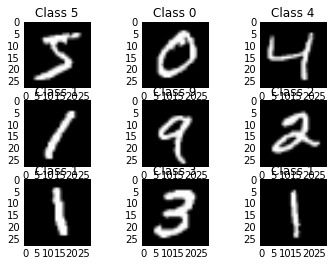

In [5]:
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Class {}'.format(y_train[i]))

### Paso 3: Preprocesamiento de los datos
La red neuronal necesita como entrada un tensor. En el caso de Tensorflow, el formato del tensor debe ser (Batch,Height,Width,Channels). Este formato varía según el framework de deep learning que se utilice. Por ejemplo, Torch utiliza el formato (B,C,H,W).

Como las imágenes son en blanco y negro, el número de canales es **1**. Si las imágenes fuesen en color, los canales serían **3**, que son los correspondientes a RGB.

Siempre es recomendable escalar los valores de entrada cuando se usan modelos de redes neuronales. Actualmente el rango de los valores de los píxeles de las imágenes es [0,255]. En este caso, normalizamos los valores al rango [0,1].

In [6]:
#Normalize
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
print('Source')
print(x_train[0])

x_train = x_train / 255
x_test = x_test / 255
print('Normalized')
print(x_train[0])

Source
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.

In [7]:
# Reshape x_train and x_test
x_train = x_train.reshape(num_training_im, height, width, 1)
x_test = x_test.reshape(num_testing_im, height, width, 1)
print('Training matrix shape', x_train.shape)
print('Testing matrix shape', x_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


#### One-hot enconding
Necesitamos que el tensor y_train tenga la forma (Batch,NumClasses), es decir, que tenga 10 clases, una para cada dígito. Sin embargo, y_train es un array de una dimensión que almacena los valores de las etiquetas de los dígitos: 5, 0, 4, 1, 9...

Hay que transformar y_train al formato one-hot para que el tensor pase a tener la forma (60000,10).

```
0->[1,0,0,0,0,0,0,0,0,0]
1->[0,1,0,0,0,0,0,0,0,0]
2->[0,0,1,0,0,0,0,0,0,0]
```

In [8]:
print('y_train shape:{}'.format(y_train.shape))
print(y_train[0:3])
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_train[0:3])
print('y_train shape:{}'.format(y_train.shape))

y_train shape:(60000,)
[5 0 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
y_train shape:(60000, 10)


### Paso 4: Construir la arquitectura de la red neuronal
<img src="Cover.png">

#### Cómo funciona una neurona:
<img src="neuron_model.jpeg" width="500">

#### Capas más utilizadas:
- **Conv**: Calcula la salida de las neuronas mediante un dot product entre los pesos y los valores de entrada. Hay que indicar el número de filtros o kernels, y el tamaño de los mismos.
<img src="convolution_schematic.gif">
<img src="giphy.gif">
<img src="conv_example.png">
http://cs231n.github.io/convolutional-networks/
- **Activation** = Función de activación no lineal. La más común es **ReLU** (rectified linear unit): ```f(x) = max(0,x)```. En otras palabras, reemplaza todos los valores de los píxeles negativos del mapa de características por 0. El propósito de esta capa es añadir el factor de no linearidad a la red convolucional (la convolución es una operación lineal (multiplicación de mattriz y suma).
<img src="relu.png">
<img src="relu2.png">
- **Avg/Max Pooling**: Operación para reducir la dimensionalidad espacial (width, height). Los mapas de características son más pequeños y por lo se manejan mejor, el coste computacional es menor (menos parámetros), controlan el sobreentrenamiento, y hacen que la red sea invariante a pequeñas transformaciones, traslaciones y distorsiones. Una pequeña distorsión en la entrada no cambiará la salida del Pooling ya que se toma la media/máximo local de varios vecinos.
<img src="maxpooling.png">
<img src="maxpooling2.png">
<img src="maxpooling3.png">
- **Fully-connected (Dense)**: Cada neurona de la capa previa está conectada a todas las neuronas de la capa siguiente. Se utiliza normalmente como última capa para calcular las puntuaciones de cada clase, es decir, clasifica los mapas de características extraídos por las capas anteriores.
<img src="fc.png">
- **Dropout** = Ayuda a proteger el modelo para que no haya sobre entrenamiento con los datos de entrenamiento.
- **BatchNormalization**. Elimina la necesidad de utilizar Dropout en muchos casos. Obtiene el accuracy de modelos del estado del arte, con 14 veces menos pasos de entrenamiento. https://arxiv.org/abs/1502.03167

#### Cómo quedan todas estas capas juntas
<img src="cnn2.png">
<img src="convnet.jpeg">
https://youtu.be/AgkfIQ4IGaM

http://scs.ryerson.ca/~aharley/vis/conv/flat.html

#### Qué es sobre entrenamiento (overfitting)
<img src="model_complexity_error_training_test.jpg">

#### Cómo se inicializan los pesos de las capas convolucionales
Los pesos de las capas convolucionales son inicializados automáticamente por Keras utilizando una determinada función. Pueden ser tensores inicializados con ceros, con unos, con una distribución normal, con la matriz identidad, etc. Es un campo activo/común de investigación. https://keras.io/initializers/ https://intoli.com/blog/neural-network-initialization/

### 4.1: Red fully-connected (sin convoluciones)

In [9]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(height, width, 1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 64)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 64)        4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                501770    
Total params: 506,058
Trainable params: 506,058
Non-trainable params: 0
_________________________________________________________________


#### Qué función tienen los optimizadores
Minimizar el error que comete la red neural a la hora de clasificar los resultados, es decir, minimizar el valor de la función de pérdida (loss).
#### Qué es la función de pérdida (loss)
Función que calcula la diferencia existente entre los valores reales y los valores predichos por la red. Hay muchas funciones:
- Mean squared error (MSE)
- Mean absolute error (MAE)
- Binary crossentropy
- Categorical crossentropy
- Más en https://keras.io/losses/

#### Cuáles son los optimizadores más utilizados
- SGD
- Adam
- RMSprop
<img src="optimizers.gif" width="500">
http://ruder.io/optimizing-gradient-descent/

In [10]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 223us/step - loss: 0.3928 - acc: 0.8911 - val_loss: 0.2886 - val_acc: 0.9173
Epoch 2/5
60000/60000 [==============================] - 11s 186us/step - loss: 0.2865 - acc: 0.9189 - val_loss: 0.2686 - val_acc: 0.9222
Epoch 3/5
60000/60000 [==============================] - 11s 185us/step - loss: 0.2759 - acc: 0.9227 - val_loss: 0.2794 - val_acc: 0.9186
Epoch 4/5
60000/60000 [==============================] - 11s 184us/step - loss: 0.2677 - acc: 0.9246 - val_loss: 0.2703 - val_acc: 0.9253
Epoch 5/5
60000/60000 [==============================] - 11s 185us/step - loss: 0.2613 - acc: 0.9263 - val_loss: 0.2726 - val_acc: 0.9229


### 4.2: Red convolucional (CNN)

In [13]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5,5), padding='same',
                 activation='relu', input_shape=(height, width,1)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               117700    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 118,866
Trainable params: 118,866
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.4286 - acc: 0.8721 - val_loss: 0.1298 - val_acc: 0.9608
Epoch 2/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.1710 - acc: 0.9502 - val_loss: 0.0793 - val_acc: 0.9735
Epoch 3/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.1222 - acc: 0.9634 - val_loss: 0.0619 - val_acc: 0.9794
Epoch 4/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.1004 - acc: 0.9699 - val_loss: 0.0525 - val_acc: 0.9821
Epoch 5/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.0854 - acc: 0.9742 - val_loss: 0.0460 - val_acc: 0.9842


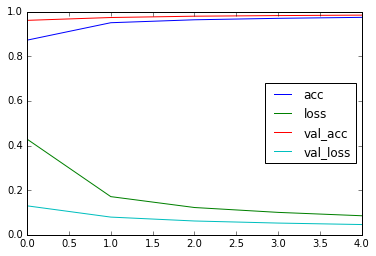

In [16]:
df = pd.DataFrame(history.history)
df.plot()

In [17]:
y_test = np.argmax(y_test, axis=1)
predicted_classes = model.predict_classes(x_test)
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print(predicted_classes[:5])

[7 2 1 0 4]


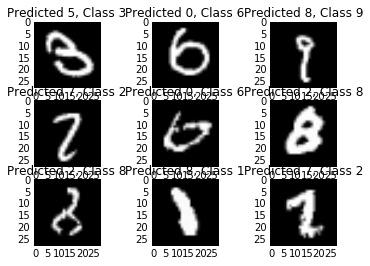

In [18]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3, i+1)
    plt.imshow(x_test[incorrect].reshape(width, height), cmap='gray')
    plt.title('Predicted {}, Class {}'.format(predicted_classes[incorrect], y_test[incorrect]))
y_test = to_categorical(y_test, num_classes)

## Paso 5: ¡Tu turno! Modifica la red convolucional para aumentar el accuracy
<img src="ur_turn.png" width="200">

In [25]:
model = Sequential()
model.add(BatchNormalization(input_shape=(height, width,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               156900    
__________

In [26]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.1913 - acc: 0.9443 - val_loss: 0.0543 - val_acc: 0.9829
Epoch 2/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0511 - acc: 0.9847 - val_loss: 0.0382 - val_acc: 0.9880
Epoch 3/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0313 - val_acc: 0.9894
Epoch 4/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0280 - acc: 0.9907 - val_loss: 0.0319 - val_acc: 0.9893
Epoch 5/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.0216 - acc: 0.9931 - val_loss: 0.0300 - val_acc: 0.9905


# Ejercicio 2: Predicción de series temporales con RNN

## Paso 1: Cargar dataset. Ibex 35 desde Enero de 2005 hasta Febrero de 2018

In [28]:
df = pd.read_csv('ibex35_monthly.csv')
df.head()

,Date,Price
0,Feb 18,"9,810.00"
1,Jan 18,"10,451.50"
2,Dec 17,"10,043.90"
3,Nov 17,"10,211.00"
4,Oct 17,"10,523.50"


## Paso 2: Preprocesamiento
Nos quedaremos solo con los valores de cierre. Queremos resolver el siguiente problema: **dado el valor de cierre del día actual, ¿cuál será el valor de cierre de mañana?**

In [29]:
prices = [float(x.replace(',','')) for x in df['Price']]
df = pd.DataFrame({'price' : prices})
df.head()

,price
0,9810.0
1,10451.5
2,10043.9
3,10211.0
4,10523.5


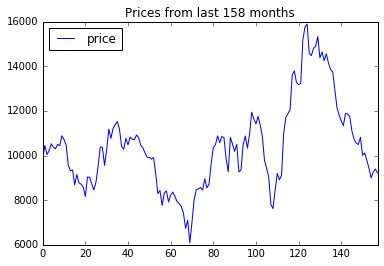

In [30]:
df.plot()
plt.title('Prices from last {} months'.format(len(df)))
dataset = df.values
dataset = dataset.astype(np.float32)

Normalizar los valores al rango [0,1]

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset[:5])

[[0.37958515]
 [0.44503963]
 [0.40345085]
 [0.42050052]
 [0.45238602]]


Dividir el dataset en entrenamiento (67%) y test (33%)

In [32]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('X_train shape:{}'.format(X_train.shape))
print('X_test shape:{}'.format(X_test.shape))

X_train shape:(105, 1)
X_test shape:(53, 1)


Creamos un dataset donde **X** sea el valor de cierre de mercado en un instante **t** e **Y** sea el valor de cierre del mercado en el siguiente instante **t+1**.

In [33]:
def create_dataset(dataset, look_back=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-look_back-1):
        val = dataset[i:(i+look_back), 0]
        X_data.append(val)
        y_data.append(dataset[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

In [34]:
look_back = 6
X_train, y_train = create_dataset(X_train, look_back)
X_test, y_test = create_dataset(X_test, look_back)

In [35]:
df_aux = pd.DataFrame({'X': np.squeeze(X_train[0:10]).tolist(), 'Y': np.squeeze(y_train[0:10]).tolist()})
df_aux.head(10)

,X,Y
0,"[0.3795851469039917, 0.44503962993621826, 0.40...",0.429531
1,"[0.44503962993621826, 0.4034508466720581, 0.42...",0.450213
2,"[0.4034508466720581, 0.4205005168914795, 0.452...",0.444325
3,"[0.4205005168914795, 0.4523860216140747, 0.437...",0.488761
4,"[0.4523860216140747, 0.43789732456207275, 0.42...",0.472007
5,"[0.43789732456207275, 0.4295305013656616, 0.45...",0.446203
6,"[0.4295305013656616, 0.4502127170562744, 0.444...",0.353618
7,"[0.4502127170562744, 0.44432544708251953, 0.48...",0.329099
8,"[0.44432544708251953, 0.48876094818115234, 0.4...",0.332864
9,"[0.48876094818115234, 0.47200703620910645, 0.4...",0.265124


## Paso 3: LSTM Network (Long Short-term memory network)
En lugar de neuronas, las redes LSTM (tipo de red recurrente) tienen bloques de memoria que están conectados a través de capas. Estos bloques tienen puertas que gestionan el estado del bloque y la salida. Hay tres tipos de puertas en una unidad LSTM:
- Forget gate: decide cuándo y qué información descartar del bloque.
- Input gate: decide los valores de la entrada que actualizarán el estado de la memoria.
- Output gate: decide cuál será la salida basándose en la entrada y en la memoria del bloque.
<img src="lstm_unit.png" width="700">

Las capas LSTM necesitan un tensor con la siguiente forma: (samples, time steps, features):
- Samples: Muestras/observaciones independientes del dominio, normalmente filas de datos.
- Time steps: Instantes de tiempo de una variable para una muestra/observación dada.
- Features: Distintas medidas observadas en el momento de la muestra.

Ejemplo:

| Date       | Open | Close |
|------------|------|-------|
| 01/01/2018 | 500  | 550   |
| 02/01/2018 | 550  | 400   |
| 03/01/2018 | 400  | 500   |

**Tensor shape: (3, 1, 2)**

#### Aplicaciones: Secuencias
- Textos
- Vídeos
- Series temporales

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [36]:
# reshape input to be [samples, time steps, features]
samples, time_steps, features = X_train.shape[0], 1, X_train.shape[1]
X_train = np.reshape(X_train, (samples, time_steps, features))
samples, time_steps, features = X_test.shape[0], 1, X_test.shape[1]
X_test = np.reshape(X_test, (samples, time_steps, features))

In [37]:
print('X_train shape:{}'.format(X_train.shape))
print('X_test shape:{}'.format(X_test.shape))

X_train shape:(98, 1, 6)
X_test shape:(46, 1, 6)


In [38]:
model = Sequential()
model.add(LSTM(units=8, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, shuffle=False)

Epoch 1/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0586
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 5/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 7/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 8/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 9/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 10/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 11/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 12/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 13/100
98/98 [=================

In [39]:
# Estimate model performance
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [40]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [41]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 540.33 RMSE
Test Score: 821.62 RMSE


## ¿Seremos ricos?
<img src="rich.jpg" width="400">

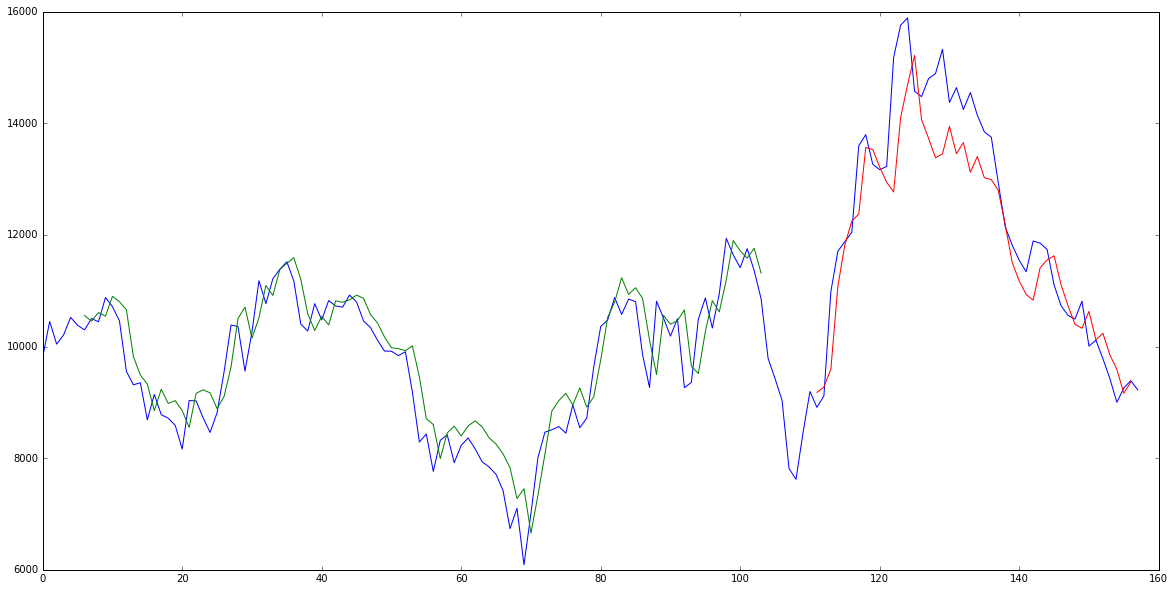

In [42]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [43]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])
    # calculate root mean squared error
    train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
    print('Test Score: %.2f RMSE' % (test_score))
    return train_predict, test_predict, y_train, y_test

In [44]:
def plot_ts(dataset, train_predict, test_predict):
    # shift train predictions for plotting
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

    # shift test predictions for plotting
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

    # plot baseline and predictions
    plt.figure(figsize=(20,10))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.show()

## Paso 4: Ibex35 con datos diarios

In [45]:
df = pd.read_csv('ibex35_daily.csv')
df.head()

,Date,Price
0,"Feb 06, 2018","9,810.00"
1,"Feb 05, 2018","10,064.50"
2,"Feb 02, 2018","10,211.20"
3,"Feb 01, 2018","10,399.00"
4,"Jan 31, 2018","10,451.50"


In [46]:
prices = [float(x.replace(',','')) for x in df['Price']]
df = pd.DataFrame({'price' : prices})

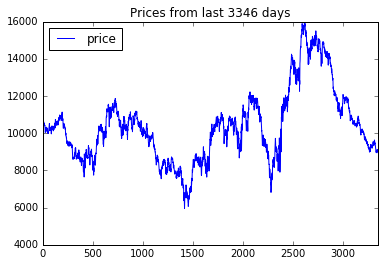

In [47]:
df.plot()
plt.title('Prices from last {} days'.format(len(df)))
dataset = df.values
dataset = dataset.astype(np.float32)

In [48]:
#normalize range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [49]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('X_train shape:{}'.format(X_train.shape))
print('X_test shape:{}'.format(X_test.shape))

X_train shape:(2241, 1)
X_test shape:(1105, 1)


In [50]:
look_back = 7
X_train, y_train = create_dataset(X_train, look_back)
X_test, y_test = create_dataset(X_test, look_back)

In [51]:
# reshape input to be [samples, time steps, features]
samples, time_steps, features = X_train.shape[0], 1, X_train.shape[1]
X_train = np.reshape(X_train, (samples, time_steps, features))
samples, time_steps, features = X_test.shape[0], 1, X_test.shape[1]
X_test = np.reshape(X_test, (samples, time_steps, features))
print('X_train shape:{}'.format(X_train.shape))
print('X_test shape:{}'.format(X_test.shape))

X_train shape:(2233, 1, 7)
X_test shape:(1097, 1, 7)


In [52]:
model = Sequential()
model.add(LSTM(units=16, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1, shuffle=False)

Epoch 1/50
2233/2233 [==============================] - 5s 2ms/step - loss: 0.0015
Epoch 2/50
2233/2233 [==============================] - 5s 2ms/step - loss: 6.3439e-04
Epoch 3/50
2233/2233 [==============================] - 5s 2ms/step - loss: 6.8296e-04
Epoch 4/50
2233/2233 [==============================] - 5s 2ms/step - loss: 7.4153e-04
Epoch 5/50
2233/2233 [==============================] - 5s 2ms/step - loss: 7.7259e-04
Epoch 6/50
2233/2233 [==============================] - 5s 2ms/step - loss: 7.5930e-04
Epoch 7/50
2233/2233 [==============================] - 5s 2ms/step - loss: 7.1726e-04
Epoch 8/50
2233/2233 [==============================] - 5s 2ms/step - loss: 6.6450e-04
Epoch 9/50
2233/2233 [==============================] - 5s 2ms/step - loss: 6.1619e-04
Epoch 10/50
2233/2233 [==============================] - 5s 2ms/step - loss: 5.7692e-04
Epoch 11/50
2233/2233 [==============================] - 5s 2ms/step - loss: 5.4576e-04
Epoch 12/50
2233/2233 [======================

In [53]:
train_predict, test_predict, y_train, y_test = evaluate_model(model, X_train, X_test, y_train, y_test)

Train Score: 542.40 RMSE
Test Score: 1975.53 RMSE


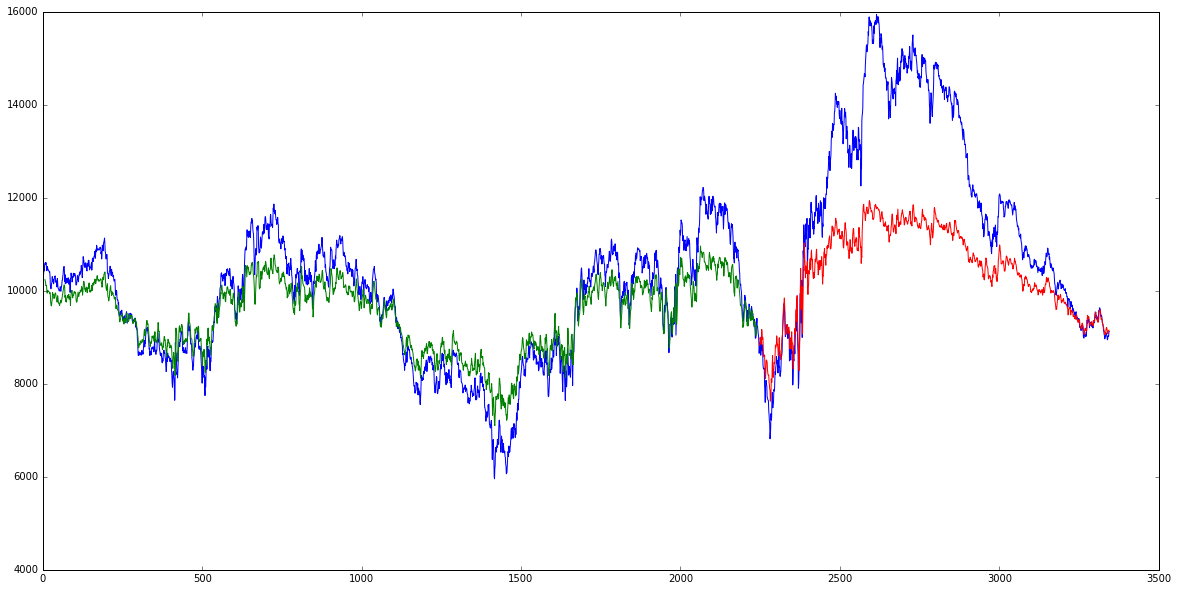

In [54]:
plot_ts(dataset, train_predict, test_predict)

## Paso 5: Predecir número de pasajeros internacionales

In [55]:
df = pd.read_csv('international-airline-passengers.csv')
df.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


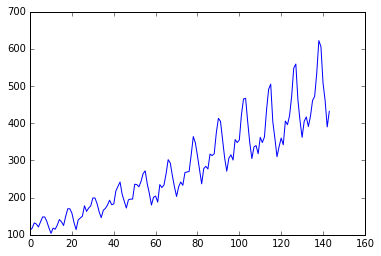

In [56]:
df = df[['passengers']]
plt.plot(df)
plt.show()
dataset = df.values
dataset = dataset.astype(np.float32)

## ¡Tu turno! Predice cuántos pasajeros tendrá la aerolínea teniendo en cuenta los 3 meses anteriores
<img src="ur_turn.png" width="200">

In [57]:
# normalization range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset[:5])

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [58]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('X_train shape:{}'.format(X_train.shape))
print('X_test shape:{}'.format(X_test.shape))

X_train shape:(96, 1)
X_test shape:(48, 1)


In [59]:
# reshape dataset
look_back = 3
X_train, y_train = create_dataset(X_train, look_back)
X_test, y_test = create_dataset(X_test, look_back)

In [60]:
#multilayer perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=2)

Epoch 1/100
 - 0s - loss: 0.0247
Epoch 2/100
 - 0s - loss: 0.0088
Epoch 3/100
 - 0s - loss: 0.0058
Epoch 4/100
 - 0s - loss: 0.0039
Epoch 5/100
 - 0s - loss: 0.0030
Epoch 6/100
 - 0s - loss: 0.0026
Epoch 7/100
 - 0s - loss: 0.0024
Epoch 8/100
 - 0s - loss: 0.0023
Epoch 9/100
 - 0s - loss: 0.0022
Epoch 10/100
 - 0s - loss: 0.0024
Epoch 11/100
 - 0s - loss: 0.0024
Epoch 12/100
 - 0s - loss: 0.0021
Epoch 13/100
 - 0s - loss: 0.0020
Epoch 14/100
 - 0s - loss: 0.0020
Epoch 15/100
 - 0s - loss: 0.0019
Epoch 16/100
 - 0s - loss: 0.0020
Epoch 17/100
 - 0s - loss: 0.0019
Epoch 18/100
 - 0s - loss: 0.0018
Epoch 19/100
 - 0s - loss: 0.0019
Epoch 20/100
 - 0s - loss: 0.0020
Epoch 21/100
 - 0s - loss: 0.0017
Epoch 22/100
 - 0s - loss: 0.0018
Epoch 23/100
 - 0s - loss: 0.0018
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0018
Epoch 26/100
 - 0s - loss: 0.0018
Epoch 27/100
 - 0s - loss: 0.0019
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0019
Epoch 30/100
 - 0s - lo

In [61]:
train_predict, test_predict, y_train, y_test = evaluate_model(model, X_train, X_test, y_train, y_test)

Train Score: 20.22 RMSE
Test Score: 58.42 RMSE


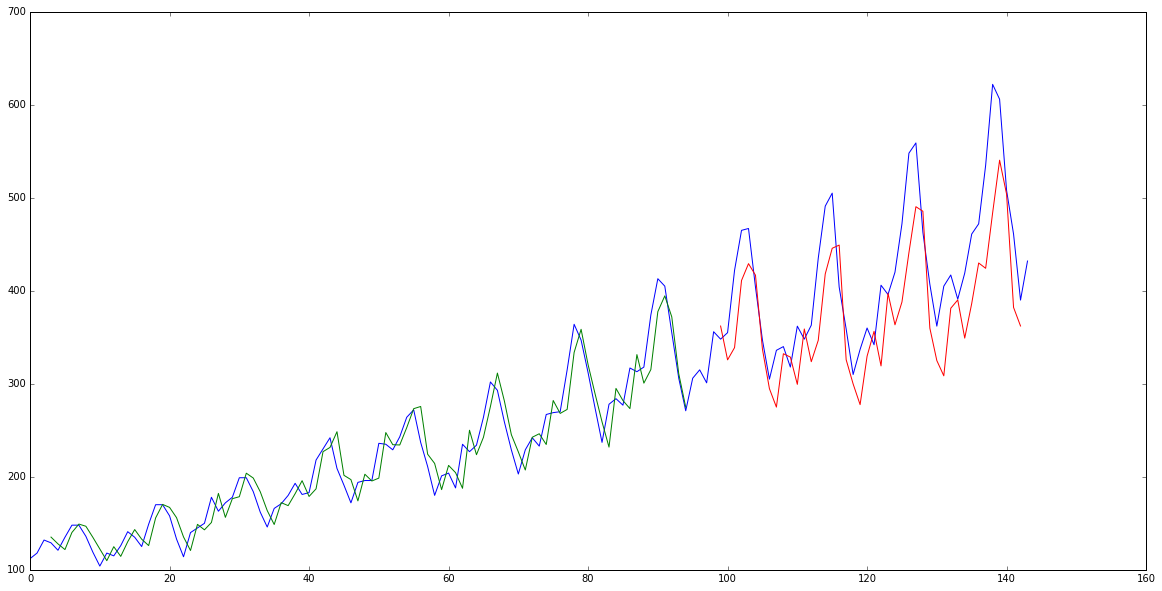

In [62]:
plot_ts(dataset, train_predict, test_predict)